In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

g = torch.Generator().manual_seed(123123)

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(".".join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {c:i for i,c in stoi.items()}

In [3]:
# Build dataset

def build_dataset(n, data, splits):
  X, Y = [], []
  for w in data:
    padding = [0]*n
    for ch in w + '.':
      ix = stoi[ch]
      X.append(padding)
      Y.append(ix)
      padding = padding[1:] + [ix] #sliding window
  X,Y = torch.tensor(X),torch.tensor(Y)
  tr, va, te = splits
  tr = int(X.shape[0]*0.8)
  va = int(X.shape[0]*0.1)

  xtrain, ytrain = X[:tr], Y[:tr]
  xvalid, yvalid = X[tr:tr+va], Y[tr:tr+va]
  xtest, ytest = X[tr+va:], Y[tr+va:]
  return [xtrain, ytrain, xvalid, yvalid, xtest, ytest]

xtrain, ytrain, xvalid, yvalid, xtest, ytest = build_dataset(n=3, data=words, splits=(0.8, 0.1, 0.1))

In [16]:
# Hyperparameters
n = 3 # trigram model
emb_sz = 10
n_hidden = 200
vocab_sz = len(chars) # it's 27

# embedding matrix -> Hidden layer -> output layer
C  = torch.randn(vocab_sz, emb_sz,   generator=g) * 0.3
w1 = torch.randn(n*emb_sz, n_hidden, generator=g) * 5/3 / (n*emb_sz)**0.5
b1 = torch.randn(n_hidden,           generator=g) * 0.01
w2 = torch.randn(n_hidden, vocab_sz, generator=g) * 0.01
b2 = torch.randn(vocab_sz,           generator=g) * 0


# Setting up gradient requirements
parameters = [C, b1, w1, w2, b2]
for p in parameters:
  p.requires_grad = True

# track stats
lossi = []
stepi = []
ud = [] # update:data ratio

sum([p.nelement() for p in parameters])

11897

torch.Size([30, 200]) torch.Size([200])


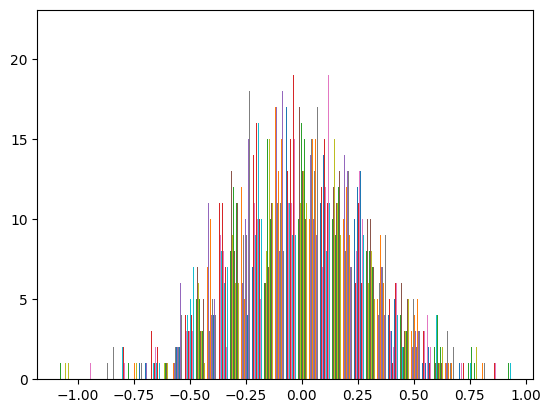

In [5]:
# visualizing "standardization" or "z-score normalization"
w1 = torch.randn(n*emb_sz, n_hidden, generator=g) * 0.01
w1mean = w1.mean(0, keepdim=True)
w1std = w1.std(0, keepdim=True)
print(w1.shape, b1.shape)
# z-score normalization and normalize between -1 and 1
plt.hist((((w1 - w1mean) / w1std) * 5/3 / (n*emb_sz)**0.5).tolist(), 40);

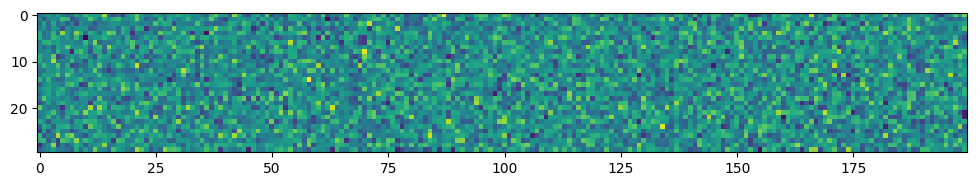

In [6]:
w1 = torch.randn(n*emb_sz, n_hidden, generator=g) * 5/3 / (n*emb_sz)**0.5

plt.figure(figsize=(12,12))
plt.imshow(w1.tolist());

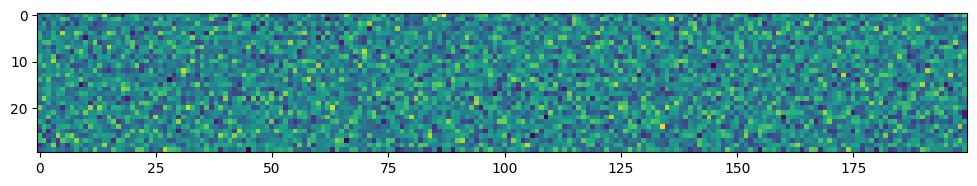

In [7]:
w1mean = w1.mean(0, keepdim=True)
w1std = w1.std(0, keepdim=True)
plt.figure(figsize=(12,12))
plt.imshow((((w1 - w1mean) / w1std)* 5/3 / (n*emb_sz)**0.5).tolist());

### Batch Normalization
Basically we want out hidden state (h) neither to big because of which it will be squashed to 1 and -1 and nor near zero  , then why dont we take them and normalize them to be gaussian?

Batchnorm is applied to the input of the next layer.

weight Layer -> BatchNorm -> Non linearity

In [17]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# for validation
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

In [18]:
epoch = 2000
bs = 64
lossi = []

for i in range(epoch):
  # mini batch
  idx = torch.randint(0, xtrain.shape[0], size=(bs,))
  xbs, ybs = xtrain[idx], ytrain[idx] #batch

  # forward pass
  emb = C[xbs]
  hpreact = emb.view(emb.shape[0], -1) @ w1 # + b1
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, ybs)
  perplexity = torch.exp(loss)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01 if i < 100_000 else 0.001
  for p in parameters:
    if p.grad is not None:
      p.data += p.grad * -lr

  # track
  lossi.append(loss.log10().item())
  # with torch.no_grad():
  #   ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i%10000 == 0:
    print(f"epoch: {i:7d}/{epoch:7d} | loss: {loss.item():.4f} | perplexity: {perplexity.item():.4f}")

epoch:       0/   2000 | loss: 3.3099 | perplexity: 27.3825


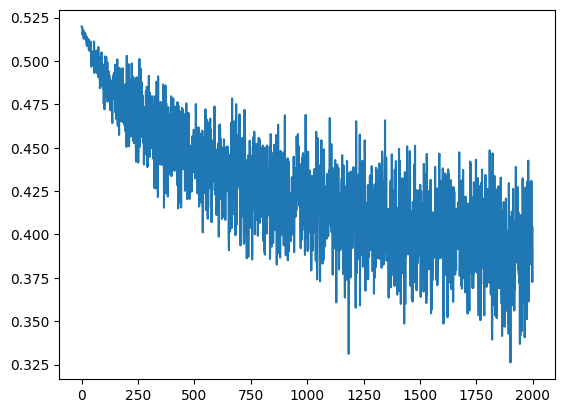

In [19]:
plt.plot(lossi);

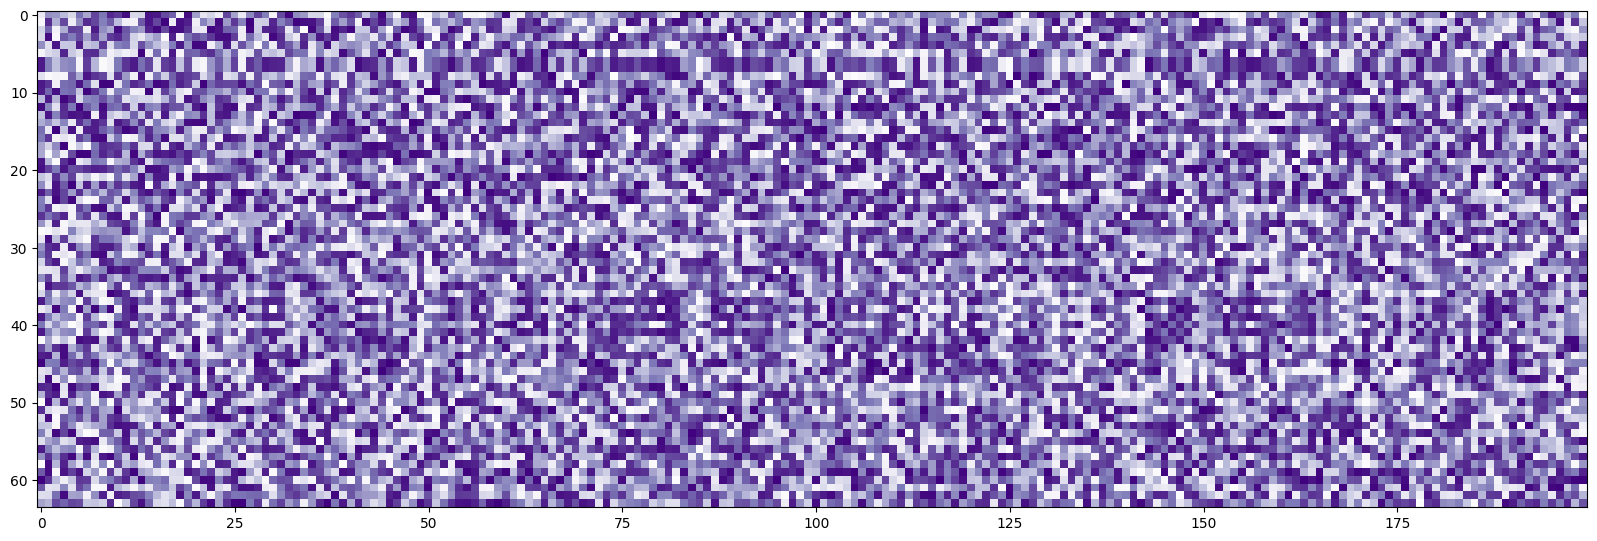

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs().tolist(), cmap='Purples');

instead of using z-score of test and valid batch, we have to use what we trained.
But this is not done in practice, because this is an extra step between training and testing a model. Instead we keep the track of std and mean while training, i.e running mean and std.

In [ ]:
# with torch.no_grad():
#   emb = C[xtrain]
#   hpreact = emb.view(xtrain.shape[0], -1) @ w1 # + b1
#   hgmean = hpreact.mean(0,keepdim=True)
#   hbstd = hpreact.std(0,keepdim=True)

In [24]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (xtrain, ytrain),
    'val'  : (xvalid, yvalid),
    'test' : (xtest , ytest),
  }[split]
  emb = C[x]
  hpreact = emb.view(emb.shape[0], -1) @ w1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h@w2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.4881908893585205
val 2.6273694038391113


In [26]:
#Sampling
with torch.no_grad():
  for _ in range(4):
    padding = [0]*n
    out = []
    while True:
      idx = 0
      emb = C[torch.tensor([padding])]
      hpreact = emb.view(1,-1) @ w1
      hpreact = bngain * (hpreact - bnmean_running / bnstd_running) + bnbias
      h = torch.tanh(hpreact)
      logits = torch.softmax(h@w2 + b2, 1)
      idx = torch.multinomial(logits, num_samples=1, replacement=True)
      padding = padding[1:] + [idx]
      out.append(itos[idx.item()])
      if idx == 0: break

    print("".join(out))

zql.
wgsa.
uhnalantei.
fksom.


**pytorch implementation**

In [196]:
class Linear:
  def __init__(self, fanin, fanout, bias=True):
    self.w = torch.randn((fanin, fanout), generator=g) / fanin**0.5
    self.b = torch.randn(fanout, generator=g) * 0.01 if bias else None

  def __call__(self, x):
    self.out = x @ self.w
    if self.b is not None:
      self.out += self.b
    return self.out

  def parameters(self):
    return [self.w] + ([self.b] if self.b else [])

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, unbiased=False, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [197]:
# Hyperparameters
n = 3 # trigram model
emb_sz = 10
n_hidden = 100
vocab_sz = len(chars) # it's 27

# -----------------------------------------------

C = torch.randn(vocab_sz, emb_sz, generator=g) 
layers = [
  Linear(emb_sz*n, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_sz, bias=False), BatchNorm1d(vocab_sz)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  for l in layers[:-1]:
    if isinstance(l, Linear):
      l.w *= 1.0

parameters = [C] + [p for l in layers for p in l.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

47024


In [198]:
epoch = 20000
bs = 32
lossi = []
ud = []

for i in range(epoch):
  # mini batch
  idx = torch.randint(0, len(xtrain), (bs,), generator=g)
  Xb, Yb = xtrain[idx], ytrain[idx]
  # forward
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)
  perplexity = torch.exp(loss)

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #step
  lr = 0.01 if i < 150000 else 0.001
  for p in parameters:
    p.data -= p.grad * lr

  #track
  lossi.append(loss.item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i%100 == 0:
    print( f"epoch {i:7d}/{epoch}   |   {loss.item():.4f}   |   perx: {perplexity.item():.4f}")


epoch       0/20000   |   3.3056   |   perx: 27.2652
epoch     100/20000   |   3.2400   |   perx: 25.5348
epoch     200/20000   |   3.1552   |   perx: 23.4585
epoch     300/20000   |   3.1343   |   perx: 22.9729
epoch     400/20000   |   2.9765   |   perx: 19.6192
epoch     500/20000   |   3.0426   |   perx: 20.9598
epoch     600/20000   |   2.9243   |   perx: 18.6212
epoch     700/20000   |   2.9431   |   perx: 18.9746
epoch     800/20000   |   2.7778   |   perx: 16.0831
epoch     900/20000   |   2.7860   |   perx: 16.2167
epoch    1000/20000   |   2.7030   |   perx: 14.9249
epoch    1100/20000   |   2.8019   |   perx: 16.4762
epoch    1200/20000   |   2.7259   |   perx: 15.2699
epoch    1300/20000   |   2.7281   |   perx: 15.3041
epoch    1400/20000   |   2.6197   |   perx: 13.7310
epoch    1500/20000   |   2.6625   |   perx: 14.3316
epoch    1600/20000   |   2.6108   |   perx: 13.6103
epoch    1700/20000   |   2.7052   |   perx: 14.9580
epoch    1800/20000   |   2.6034   |   perx: 1

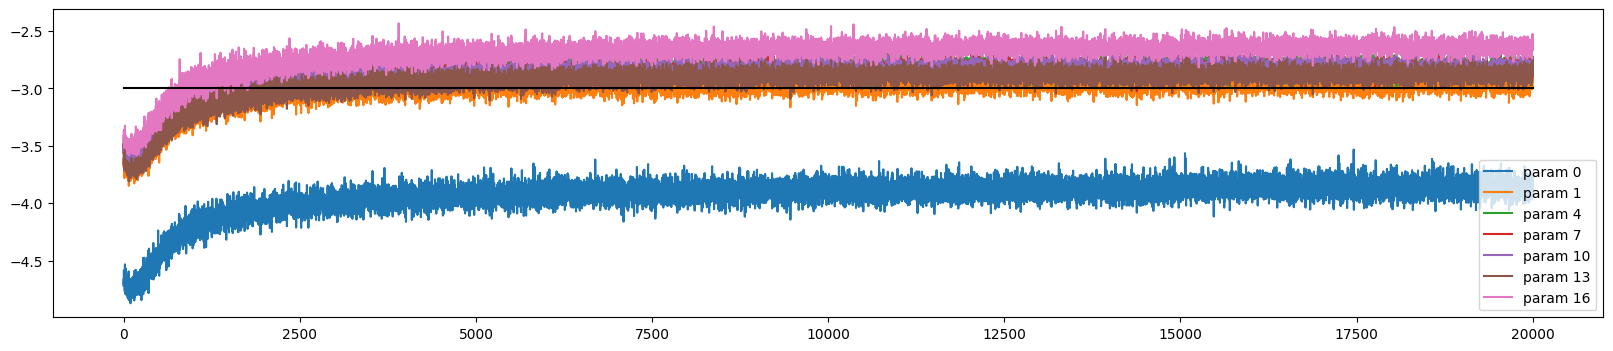

In [199]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append(f"param {i}")
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

layer 2 (      Tanh): mean +0.01, std 0.62, saturated: 3.97%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 4.12%
layer 8 (      Tanh): mean +0.01, std 0.65, saturated: 3.50%
layer 11 (      Tanh): mean -0.00, std 0.66, saturated: 2.88%
layer 14 (      Tanh): mean -0.01, std 0.67, saturated: 2.38%


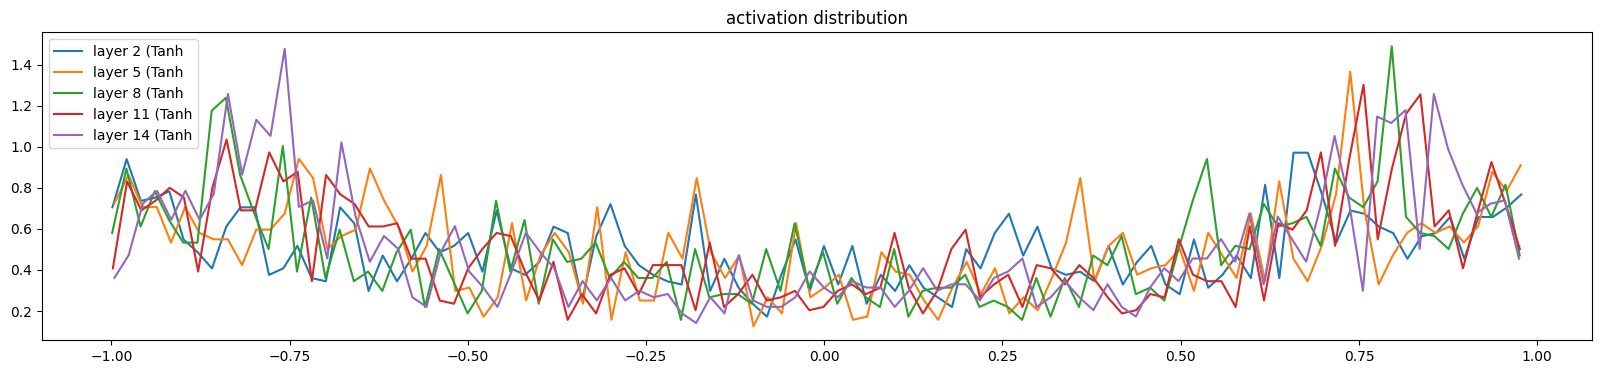

In [200]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

In [201]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (xtrain, ytrain),
    'val': (xvalid, yvalid),
    'test': (xtest, ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.1661159992218018
val 2.422011375427246


In [204]:
# sample from the model
with torch.no_grad():
  for _ in range(20):
      out = []
      context = [0] * 3 # initialize with all ...
      while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
          x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(itos[i] for i in out)) # decode and print the generated word

adi.
kynne.
imrat.
elibger.
marx.
icose.
jodlora.
ley.
kgal.
verengssa.
arolyne.
bolenner.
kam.
sheran.
coriah.
jeanna.
cryhtire.
rakeylianre.
adelianhza.
aasiyuniz.
